In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMU_MITB_AML/Project/CS610_AML/Non-Sus

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1wyO35GiaMELX5uUD8ZenhccOlW8RA1Dl/CS610_AML/Non-Sus


In [ ]:
!pip install torchmetrics

In [3]:
from PIL import Image, ImageDraw, ImageFilter, ImageFont
import cv2
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager as fm
from IPython.display import display
import warnings
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from collections import defaultdict
from torchvision.ops import box_iou

warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
model_id = "IDEA-Research/grounding-dino-tiny"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

### Functions

In [8]:
def get_bboxes(image, text_labels):
    res = []

    for label in text_labels:
        inputs = processor(images=image, text=label, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        temp_res = processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=0.4,
            text_threshold=0.3,
            target_sizes=[image.size[::-1]]
        )
        if len(temp_res[0]["scores"]) > 0:
            res.append(temp_res[0])
    if res:
        processed_res = {
            "scores": torch.cat([r["scores"] for r in res], dim=0),
            "boxes": torch.cat([r["boxes"] for r in res], dim=0),
            "text_labels": sum([r["text_labels"] for r in res], []),
            "labels": sum([r["labels"] for r in res], [])
        }
    else:
        processed_res = None

    return processed_res


def calc_overlap(face_box, main_char_box):
    x1 = max(face_box[0], main_char_box[0])
    y1 = max(face_box[1], main_char_box[1])
    x2 = min(face_box[2], main_char_box[2])
    y2 = min(face_box[3], main_char_box[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    face_area = (face_box[2] - face_box[0]) * (face_box[3] - face_box[1])

    return (intersection_area / face_area) if face_area > 0 else 0


def find_main_face(main_char_res, face_res, threshold=1):
    idx = torch.argmax(main_char_res["scores"]).item() if main_char_res else -1
    if idx == -1:
        face_res["main_face_iou"] = []
        face_res["main_face_labels"] = [False for i in range(len(face_res["boxes"]))]
        return face_res

    main_char_bbox = main_char_res["boxes"][idx].cpu().tolist()
    face_bboxes = face_res["boxes"].tolist()
    res = face_res
    face_res["main_face_labels"] = []
    face_res["main_face_iou"] = []

    for id, face_bbox in enumerate(face_bboxes):
        iou = calc_overlap(face_bbox, main_char_bbox)
        res["main_face_iou"].append(iou)
        res["main_face_labels"].append(iou >= threshold)

    return res


def mask_bbox(image, res):
    blurred_image = image.filter(ImageFilter.GaussianBlur(radius=15))
    output_image = image.copy()

    for label, box in zip(res["main_face_labels"], res["boxes"]):
        if not label:
            x1, y1, x2, y2 = map(int, box)
            face_region = blurred_image.crop((x1, y1, x2, y2))

            mask = Image.new('L', face_region.size, 0)
            mask_draw = ImageDraw.Draw(mask)
            mask_draw.ellipse((0, 0, face_region.width, face_region.height), fill=255)
            output_image.paste(face_region, (x1, y1, x2, y2), mask)

    return output_image


def draw_bbox(image, main_char_res=None, face_res=None):
    output_image = image.copy()
    draw = ImageDraw.Draw(output_image)
    font = ImageFont.truetype(fm.findfont(fm.FontProperties(family='DejaVu Sans')), 16)

    if main_char_res is not None:
        for score, label, box in zip(main_char_res["scores"], main_char_res["labels"], main_char_res["boxes"]):
            box = [round(i, 2) for i in box.tolist()]
            draw.rectangle(box, outline="red", width=3)
            draw.text((box[0], box[1]), f"{label}: {round(score.item(), 2)}", fill="red", font=font)

    if face_res is not None:
        for score, label, box in zip(face_res["scores"], face_res["labels"], face_res["boxes"]):
            box = [round(i, 2) for i in box.tolist()]
            draw.rectangle(box, outline="blue", width=3)
            draw.text((box[0], box[1]), f"{label}: {round(score.item(), 2)}", fill="blue", font=font)

    return output_image


def generate_labels(image_path, results):
    image = Image.open(image_path).convert("RGB")

    main_char_text_labels = MAIN_CHAR_LABELS
    main_char_res = get_bboxes(image, main_char_text_labels)

    face_text_labels = [["face"]]
    face_res = get_bboxes(image, face_text_labels)

    res = find_main_face(main_char_res, face_res)

    temp = pd.DataFrame.from_dict({"image_name": image_path, "bbox": res["boxes"].tolist(), "label": res["main_face_labels"], "score": res["scores"].tolist()})
    results = pd.concat([results, temp])
    return results


def mask_image(image_path, show_bbox=False):
    if isinstance(image_path, str):
        image = Image.open(image_path).convert("RGB")
    else:
        image = image_path

    main_char_text_labels = MAIN_CHAR_LABELS
    main_char_res = get_bboxes(image, main_char_text_labels)

    face_text_labels = FACE_LABELS
    face_res = get_bboxes(image, face_text_labels)

    res = find_main_face(main_char_res, face_res)
    print(res)

    if show_bbox:
        return draw_bbox(image, main_char_res, face_res)
    else:
        return mask_bbox(image, res)


def format_data(df):
    grouped = df.groupby("image_name")
    result = []

    for image_id, group in grouped:
        boxes = torch.tensor(group["bbox"].tolist(), dtype=torch.float)
        labels = torch.tensor(group["label"].tolist(), dtype=torch.int)
        item = {"image_name": image_id, "boxes": boxes, "labels": labels}
        if "score" in group.columns:
            item["scores"] = torch.tensor(group["score"].tolist(), dtype=torch.float)
        result.append(item)

    return result

def plot_predictions_and_labels(image_path, preds, labels, class_names=None):
    preds = [x for x in preds if x["image_name"] == image_path]
    labels = [x for x in labels if x["image_name"] == image_path]
    image = Image.open(image_path).convert("RGB")

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    pred_boxes = preds[0]["boxes"]
    pred_scores = preds[0].get("scores", None)
    pred_labels = preds[0]["labels"]

    for i, box in enumerate(pred_boxes):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                 edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        label = f"P: {pred_labels[i].item()}"
        if pred_scores is not None:
            label += f" ({pred_scores[i].item():.2f})"
        ax.text(x1, y1 - 4, label, color="red", fontsize=10, weight="bold")

    gt_boxes = labels[0]["boxes"]
    gt_labels = labels[0]["labels"]

    for i, box in enumerate(gt_boxes):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                 edgecolor="green", facecolor="none", linestyle='--')
        ax.add_patch(rect)
        label = f"G: {gt_labels[i].item()}"
        ax.text(x1, y2 + 4, label, color="green", fontsize=10, weight="bold")

    plt.axis("off")
    plt.title("Red: Predictions | Green: Ground Truths")
    plt.show()

### Results (Images)

In [6]:
MAIN_CHAR_LABELS = [["main character", "vlogger", "selfie taker"], ["main character of the photo", "person who is vlogging", "person taking the selfie", "person in the foreground"]]
MAIN_CHAR_LABELS = [["main character", "vlogger", "selfie taker"], ["person taking the selfie"]]
FACE_LABELS = [["face"]]

{'scores': tensor([0.7924, 0.6511, 0.6884, 0.5794, 0.5616], device='cuda:0'), 'boxes': tensor([[ 365.0793,  485.6450,  614.5008,  851.0024],
        [ 997.2441,  365.1364, 1106.4716,  476.6042],
        [  54.4013,  182.1960,  210.8273,  363.5832],
        [ 799.4837,   55.5846,  887.9342,  153.4430],
        [ 417.1165,   54.7352,  500.7171,  171.2293]], device='cuda:0'), 'text_labels': ['face', 'face', 'face', 'face', 'face'], 'labels': ['face', 'face', 'face', 'face', 'face'], 'main_face_labels': [True, False, False, False, False], 'main_face_iou': [1.0, 0.0, 0.0, 0.0, 0.0]}


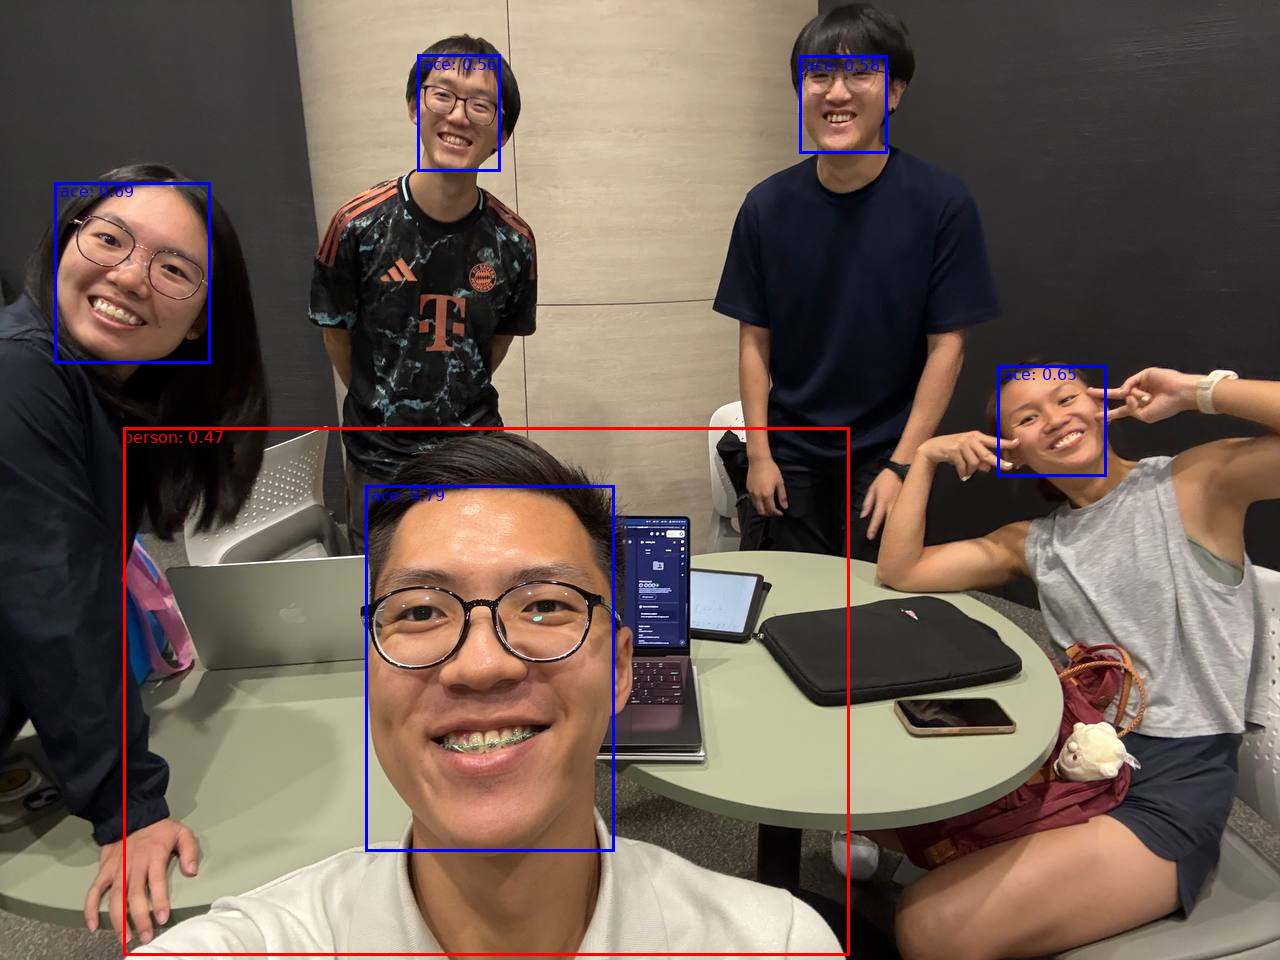

In [9]:
mask_image("image_455.jpg", True)

### Metrics (Images)

In [11]:
results = pd.DataFrame()
errors = 0
pbar = tqdm(os.listdir(), desc=f"Processing Images ({errors} Errors)")

for file in pbar:
    try:
        if file == "Labels":
            continue
        results = generate_labels(file, results)
    except Exception as e:
        errors += 1
        pbar.set_description(f"Processing Images ({errors} Errors)")
        continue

results["x1"] = results["bbox"].apply(lambda x: x[0])
results.sort_values(["image_name", "x1"], inplace=True)
results.drop(columns="x1", inplace=True)

Processing Images (37 Errors): 100%|██████████| 477/477 [11:21<00:00,  1.43s/it]


In [13]:
actual_df = pd.read_csv("../Labels/Annotations.csv")
actual_df["bbox"] = actual_df[["x1", "y1", "x2", "y2"]].values.tolist()
actual_df["label"] = actual_df["label"].apply(lambda x: 0 if x else 1)
actual_df.sort_values(["image_name", "x1"], inplace=True)
actual_df = actual_df.drop(["x1", "y1", "x2", "y2"], axis=1)
actual_df = actual_df[actual_df["image_name"].isin(results["image_name"].unique())]

In [14]:
preds = format_data(results)
labels = format_data(actual_df)

metric = MeanAveragePrecision(iou_type="bbox")
metric.update(preds, labels)
map_results = metric.compute()
print(map_results)

{'map': tensor(0.4194), 'map_50': tensor(0.5153), 'map_75': tensor(0.4913), 'map_small': tensor(0.1200), 'map_medium': tensor(0.5480), 'map_large': tensor(0.4182), 'mar_1': tensor(0.2915), 'mar_10': tensor(0.5399), 'mar_100': tensor(0.5482), 'mar_small': tensor(0.1280), 'mar_medium': tensor(0.7103), 'mar_large': tensor(0.5636), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1], dtype=torch.int32)}


In [15]:
metric = MeanAveragePrecision()

image_ids = results["image_name"].unique()
per_image_aps = {}

for image_id in image_ids:
    preds_for_img = [p for p in preds if p["image_name"] == image_id]
    gts_for_img = [g for g in labels if g["image_name"] == image_id]

    metric.reset()
    metric.update(preds_for_img, gts_for_img)
    result = metric.compute()
    per_image_aps[image_id] = result["map"].item()

low_ap_images = [img for img, ap in per_image_aps.items() if ap < 0.5]

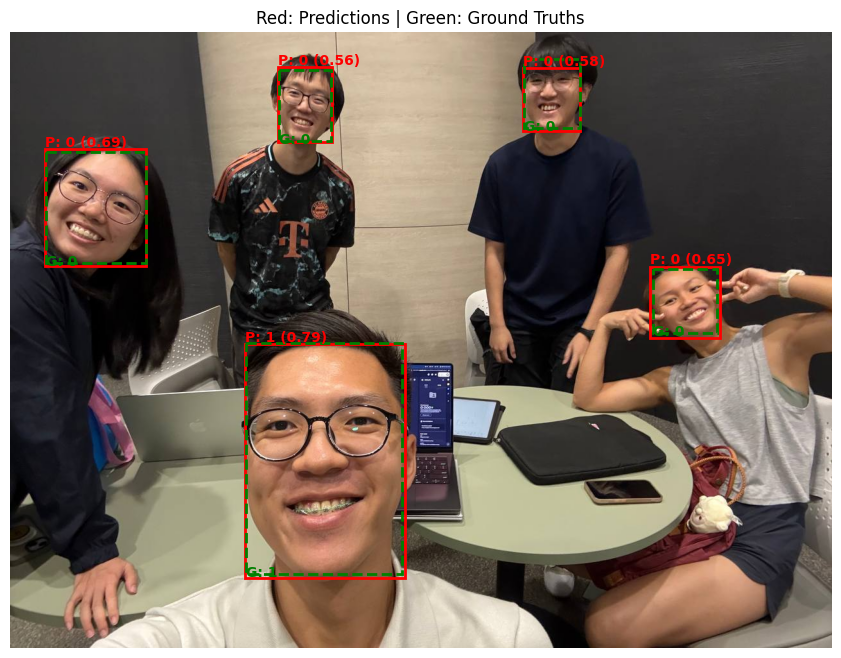

In [16]:
plot_predictions_and_labels("image_455.jpg", preds, labels)

In [17]:
def compute_f1(df_gt, df_pred, iou_threshold=0.5):
    stats = defaultdict(lambda: {"tp": 0, "fp": 0, "fn": 0, "support": 0})

    for image_id in df_gt["image_name"].unique():
        gt = df_gt[df_gt["image_name"] == image_id]
        pred = df_pred[df_pred["image_name"] == image_id]

        gt_boxes = torch.tensor(gt["bbox"].tolist(), dtype=torch.float)
        gt_labels = torch.tensor(gt["label"].tolist())

        pred_boxes = torch.tensor(pred["bbox"].tolist(), dtype=torch.float)
        pred_labels = torch.tensor(pred["label"].tolist())

        if len(gt_boxes) == 0:
            for label in pred_labels.tolist():
                stats[int(label)]["fp"] += 1
        if len(pred_boxes) == 0:
            for label in gt_labels.tolist():
                stats[int(label)]["fn"] += 1
                stats[int(label)]["support"] += 1

        ious = box_iou(pred_boxes, gt_boxes)
        matched_gt = set()

        for pred_idx in range(len(pred_boxes)):
            iou_vals = ious[pred_idx]
            max_iou, gt_idx = torch.max(iou_vals, dim=0)
            pred_label = pred_labels[pred_idx].item()
            gt_label = gt_labels[gt_idx].item()

            if max_iou >= iou_threshold and gt_idx.item() not in matched_gt:
                if pred_label == gt_label:
                    stats[int(pred_label)]["tp"] += 1
                else:
                    stats[int(pred_label)]["fp"] += 1
                    stats[int(not pred_label)]["fn"] += 1
                matched_gt.add(gt_idx.item())
                stats[int(gt_label)]["support"] += 1
            else:
                stats[int(pred_label)]["fp"] += 1

        for gt_idx in range(len(gt_boxes)):
            label = gt_labels[gt_idx].item()
            if gt_idx not in matched_gt:
                stats[int(label)]["fn"] += 1
                stats[int(label)]["support"] += 1

    weighted_prec_numer = 0
    weighted_recall_numer = 0
    total_support = 0

    for label, stats in stats.items():
        tp = stats['tp']
        fp = stats['fp']
        fn = stats['fn']
        support = stats['support']
        total_support += support

        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        weighted_prec_numer += prec * support
        weighted_recall_numer += recall * support

    weighted_precision = weighted_prec_numer / total_support if total_support > 0 else 0
    weighted_recall = weighted_recall_numer / total_support if total_support > 0 else 0

    weighted_f1 = (2 * weighted_precision * weighted_recall /
                  (weighted_precision + weighted_recall) if (weighted_precision + weighted_recall) > 0 else 0)

    return weighted_precision, weighted_recall, weighted_f1

In [19]:
compute_f1(actual_df[actual_df["image_name"] == "image_455.jpg"], results[results["image_name"] == "image_455.jpg"])

(1.0, 1.0, 1.0)

In [20]:
image_res = {}
for img in results["image_name"].unique():
    image_res[img] = compute_f1(actual_df[actual_df["image_name"] == img], results[results["image_name"] == img])
image_res = pd.DataFrame.from_dict(image_res, orient="index", columns=["precision", "recall", "f1"]).reset_index()
image_res.head()

,index,precision,recall,f1
0,image_001.JPEG,1.000000,1.000000,1.000000
1,image_002.jpeg,0.500000,0.500000,0.500000
2,image_005.jpeg,0.500000,0.500000,0.500000
3,image_006.jpg,0.714286,0.714286,0.714286
4,image_007.JPG,0.640000,0.800000,0.711111


In [21]:
overall_precision = image_res["precision"].mean()
overall_recall = image_res["recall"].mean()
overall_f1 = image_res["f1"].mean()
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1: {overall_f1}")

Overall Precision: 0.6895542480381279
Overall Recall: 0.660739681561857
Overall F1: 0.6654977085786542


### Result (Video)

In [ ]:
from google.colab.patches import cv2_imshow

def mask_video(video_path, show_bbox=False):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('output.mp4', fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        masked_image = mask_image(image)
        masked_frame = cv2.cvtColor(np.array(masked_image), cv2.COLOR_RGB2BGR)

        out.write(masked_frame)
        # cv2_imshow(masked_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
mask_video("video_2025-06-27_21-25-51.mp4")